# KTR Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

In [3]:
orbit.__version__

'1.1.0dev'

## Data

In [4]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

In [10]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [12]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [13]:
ktr.get_regression_coefs().head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.12392,0.06890,0.20247
1,2010-01-10,0.12379,0.06913,0.20253
2,2010-01-17,0.12367,0.06937,0.20259
3,2010-01-24,0.12354,0.06961,0.20265
4,2010-01-31,0.12342,0.06985,0.20271


In [14]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,0.13174,0.05578,0.19824
1,2011-07-03,78,0.10490,0.09653,0.21389
2,2012-12-30,156,0.12526,0.12645,0.18649
3,2014-06-29,234,0.08782,0.15611,0.14537
4,2015-12-27,312,0.10246,0.08449,0.14982
5,2017-06-25,390,0.11050,0.06855,0.16682


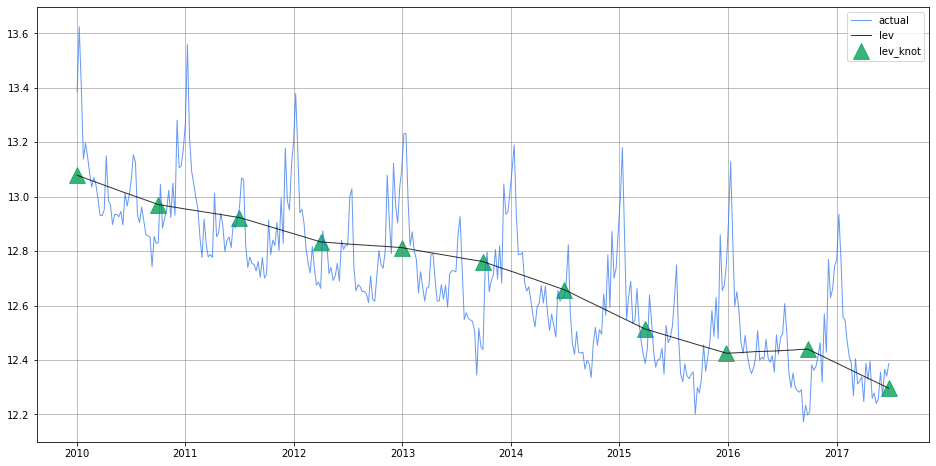

<AxesSubplot:>

In [15]:
ktr.plot_lev_knots(figsize=(16, 8), use_orbit_style=False)

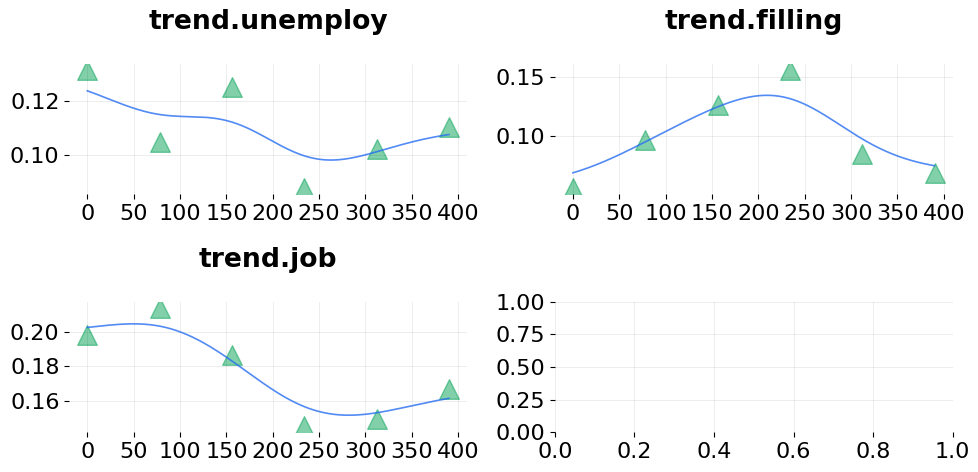

In [16]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [17]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.13847,12.29572,12.45003,12.13246,12.29385,12.44603,-0.01312,0.01880,0.04963,-0.01455,-0.01455,-0.01455
1,2017-07-09,12.15233,12.31343,12.46570,12.14460,12.30328,12.45734,0.00361,0.03444,0.06220,-0.02259,-0.02259,-0.02259
2,2017-07-16,12.12823,12.27968,12.44433,12.13783,12.29054,12.45372,-0.00004,0.02438,0.04790,-0.03450,-0.03450,-0.03450
3,2017-07-23,12.11600,12.27249,12.42191,12.13512,12.29558,12.44562,0.00493,0.02552,0.04506,-0.05014,-0.05014,-0.05014
4,2017-07-30,12.10267,12.25371,12.41536,12.13637,12.28897,12.45037,0.00835,0.03234,0.05617,-0.06903,-0.06903,-0.06903


In [18]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.71%'

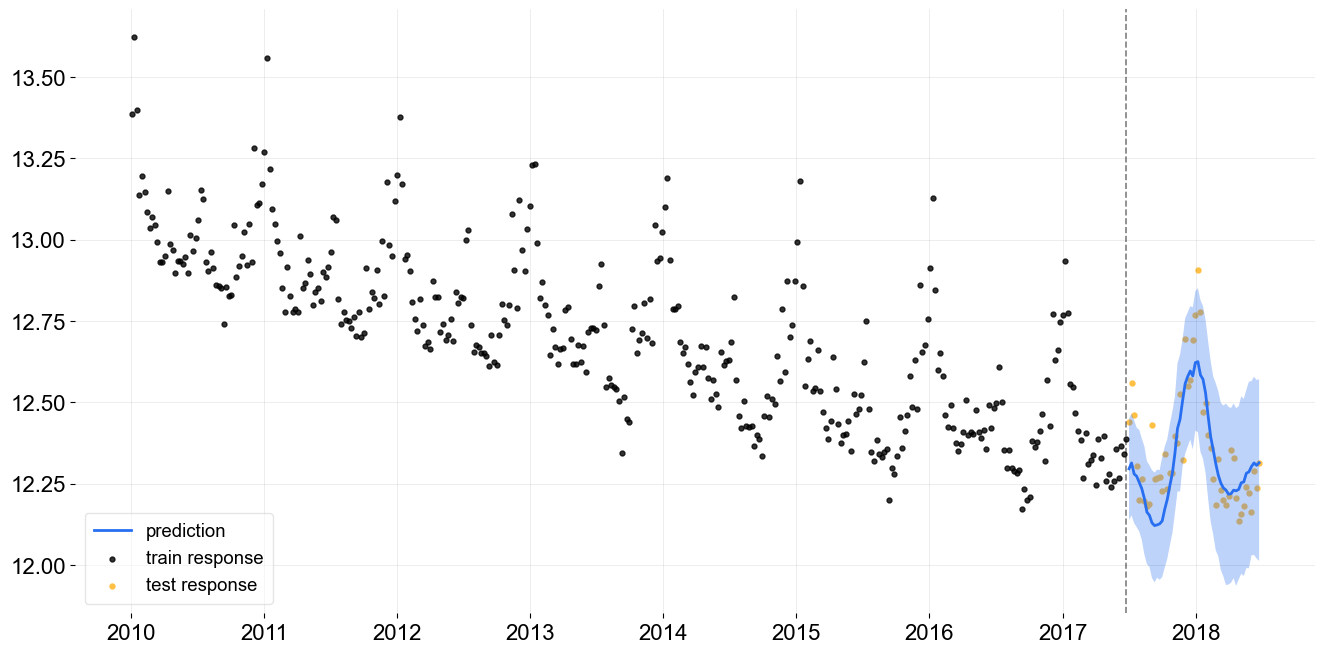

In [19]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### KTR - Median

INFO:root:Guessed max_plate_nesting = 1


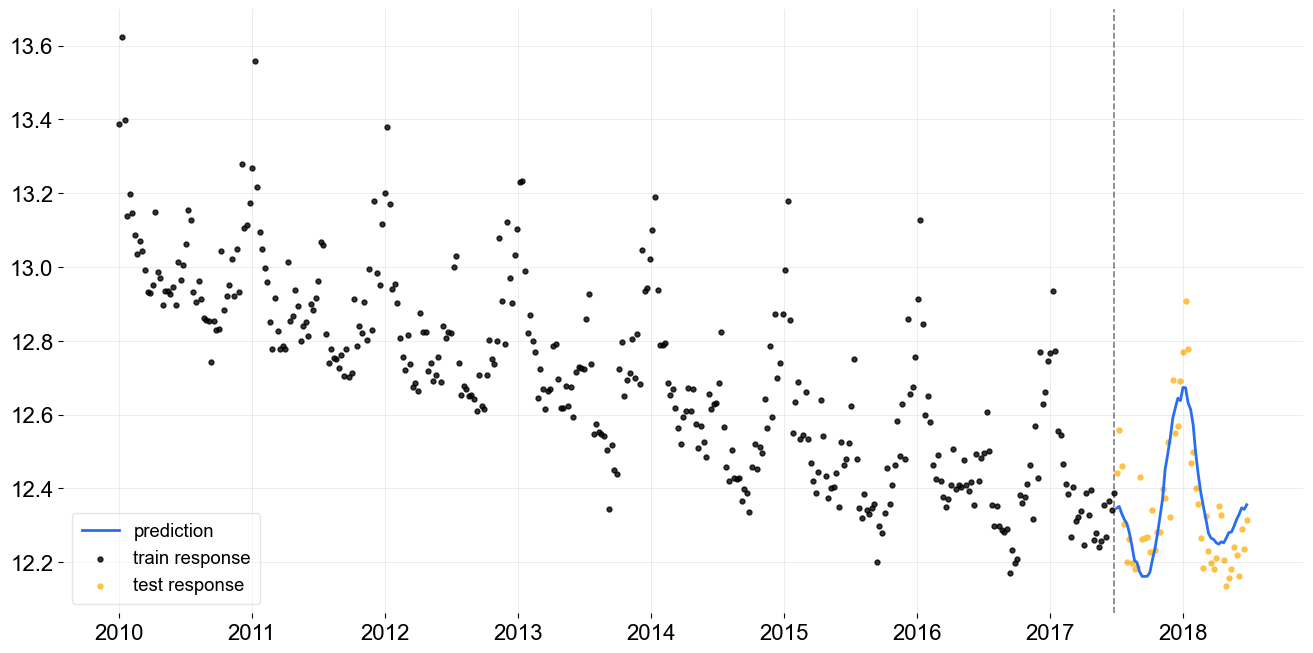

In [20]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

## Electricity data (dual seasoanlity, no regressor)

In [21]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [22]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [23]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [24]:
ktr.fit(df=train_df, point_method='median')

INFO:root:Guessed max_plate_nesting = 1


In [25]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,regression,seasonality_7,seasonality_365.25
360,2008-12-27,9.92016,9.95874,0.00000,-0.03038,-0.00819
361,2008-12-28,9.86498,9.95874,0.00000,-0.08448,-0.00928
362,2008-12-29,9.92959,9.95874,0.00000,-0.01905,-0.01009
363,2008-12-30,9.99130,9.95874,0.00000,0.04319,-0.01062
364,2008-12-31,9.97266,9.95874,0.00000,0.02480,-0.01087


In [26]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.71%'

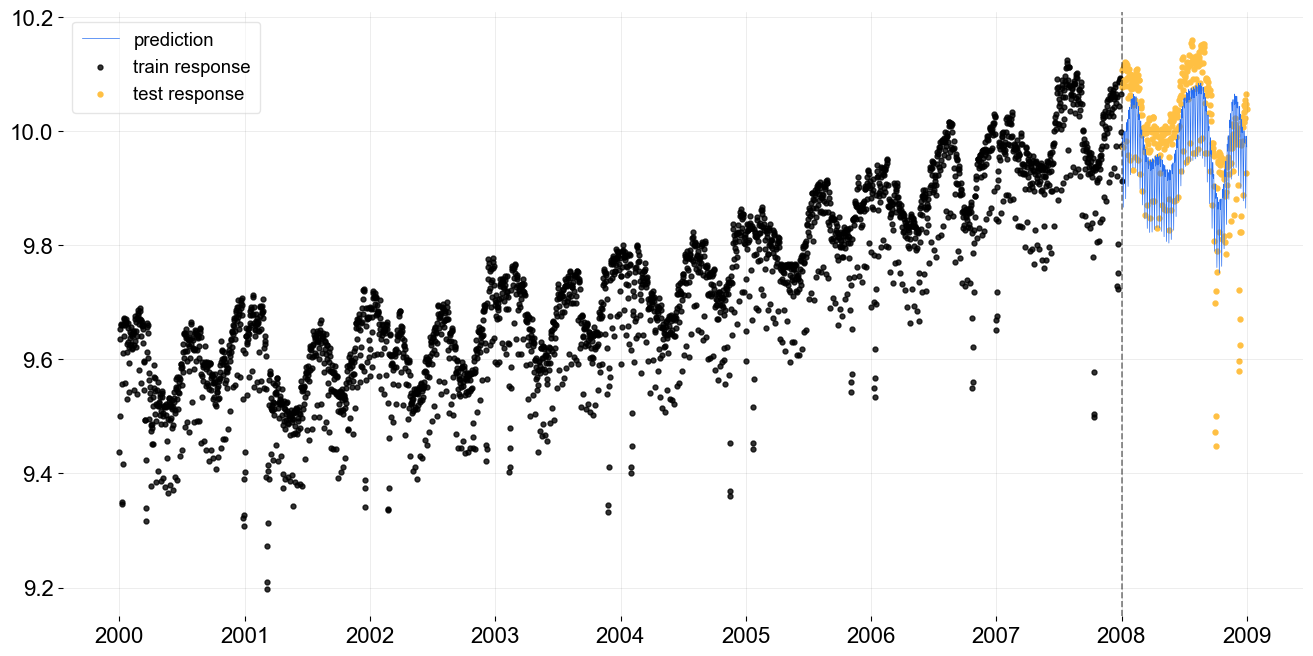

In [27]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                       lw=0.5)